# Classification

## Imports

In [265]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import anndata as ad
# import scanpy as sc
from collections import Counter
os.environ['SCIPY_ARRAY_API'] = '1'
# from imblearn import over_sampling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from flaml import AutoML
# import 

## Load  metadata

In [266]:
data = pd.read_csv('../data/processed/dataset_w_cdr_annotation.csv', index_col=0)
# data.index = data['Antibody  Name']
# data.drop('Antibody  Name', axis=1, inplace=True)
# display(data)

## Functions: Blosum encoder, ESM embeding extraction

#### function: bolsum encoder and plotter

In [267]:
from Bio.Align import substitution_matrices
from sklearn.decomposition import PCA

matrix = substitution_matrices.load("BLOSUM62")

def blosum_encode(seq):
    encoding = []
    for res in seq:
        # Get the corresponding BLOSUM vector for each residue
        index = matrix.alphabet.index(res)
        v = matrix[index, :]
        encoding.append(v)
    # Convert the list of vectors to a numpy array
    encoding = np.array(encoding)
    return encoding

def blosum_encode_seqs(seq_list):
    seq_encodings = []
    max_len = max([len(seq) for seq in seq_list])  # Find the maximum sequence length
    for seq in seq_list:
        # Get the encoding for the sequence
        seq_enc = blosum_encode(seq)
        
        # If padding is necessary, we pad the sequence along the second axis (positions)
        if len(seq) < max_len:
            pad_len = max_len - len(seq)
            seq_enc = np.pad(seq_enc, ((0, pad_len), (0, 0)), mode='constant', constant_values=0)
        
        seq_encodings.append(seq_enc)
    
    # Convert list of sequences into a single 3D numpy array
    seq_encodings = np.array(seq_encodings)
    return seq_encodings


def plot_pca(seqs, labels, output_filename=None, **kwargs):
    """
    Perform PCA on BLOSUM-encoded protein sequences and plot the results.

    Parameters:
        seqs (list of str): List of protein sequences to encode and plot.
        labels (np.ndarray): Array of labels corresponding to the sequences.
        output_filename (str, optional): File name to save the plot. If None, the plot is displayed.
        **kwargs: Additional keyword arguments for matplotlib's scatter function.

    Returns:
        None
    """
    # Perform BLOSUM encoding on the sequences
    encodings = blosum_encode_seqs(seqs)
    # Perform PCA to reduce dimensions to 2
    pca = PCA(n_components=2)
    coords = pca.fit_transform(encodings)

    # Get variance explained for each PCA component
    explained_variance = pca.explained_variance_ratio_ * 100
    x_label = f"PC1 ({explained_variance[0]:.2f}%)"
    

    y_label = f"PC2 ({explained_variance[1]:.2f}%)"


    # Plot the PCA results, grouping points by their labels
    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        idx = np.where(labels == label)
        plt.scatter(coords[idx, 0], coords[idx, 1], label=label, alpha=0.3, edgecolors="k")  # Reduced alpha for transparency

    # Add labels, legend, and adjust appearance
    plt.xlabel(x_label)
    # plt.ylabel(y_label, rotation=0, labelpad=30, ha='right')  # Rotate y-label'
    plt.ylabel(y_label, rotation=0, labelpad=10, ha='right')  # Closer to the axis
    plt.title("PCA of Encoded Sequences")
    plt.legend(title="Labels")
    plt.grid(True, linestyle='--', alpha=0.5)

    # Show plot
    plt.tight_layout()

    # Save or show the plot
    if not output_filename:
        plt.show()
    else:
        plt.savefig(output_filename)


#### Only needed if not known- Find max seq and chain for zero padding removing.

In [264]:
# embed_dir = '/home/azureuser/cloudfiles/code/Users/s184243/AI4ProtEng_AIntibody/data/interim/'

# embed_to_load = ["8M","35M"][0]
# chain_type = ["together","seperate"][0]
# linker_type = ["_<cls>","_G","_GGGGS"][0]



# with open(os.path.join(embed_dir, f'embed_EMS_{embed_to_load}_{chain_type}{linker_type}'), 'rb') as f:
#     esm_output = pickle.load(f)
#     #del esm_output["contacts"]

KeyboardInterrupt: 

In [170]:
layer = list(esm_output['representations'].keys())[0]

longest_seq = 0
longeschain = 0

where_longest = 0
for i, (index, row) in enumerate(data.iterrows()):
    chain1=len(row['Heavy chain AA'])
    chain2=len(row['Light chain AA'])
    number = chain1+chain2

    if number > longest_seq:
        longest_seq = number
        where_longest = i
    
    if chain2 > longeschain:
        longeschain = chain2
    if chain1 > longeschain:
        longeschain = chain2
    
# longest_seq = 248
# longest chain =  106
# linkersize = len(esm_output["representations"][layer][0]) -longest_seq -2 

print(longeschain)


106


#### function: extract mean represention 

In [268]:

def extract_chains(df, embedding, mean_method='full_seq',chain_choice = "together",linker_size=0):
    hc_embedding = []
    lc_embedding = []
    # print(linker_size)
    # extract embed from chains
    if chain_choice == "seperate":
        for i, (index, row) in enumerate(df.iterrows()):
            hc_embedding.append(embedding[i][1:len(row['Heavy chain AA'])+1])
            lc_embedding.append(embedding[i+len(data)][1:len(row['Light chain AA'])+1])

    elif chain_choice == "together":
    
        data[["Light chain AA","Heavy chain AA"]][0:1].values[0]
        for i, (index, row) in enumerate(df.iterrows()):
            
            # Extract heavy Chain embeddings (after <start> and before linker)
            hc_len = len(row['Heavy chain AA'])
            hc_embedding.append(embedding[i][1:hc_len+1])

            # Extract light Chain  embeddings (after linker and before <end>)
            lc_start = 1 + hc_len + linker_size

            lc_end = lc_start + len(row['Light chain AA'])

            lc_embedding.append(embedding[i][lc_start:lc_end])

    return    hc_embedding ,lc_embedding

def pooling_method(df,chains,mean_method="cdr"):
    hc_embedding=chains[0]
    lc_embedding=chains[1]

    if mean_method == 'cdr':
        for i, (index, row) in enumerate(df.iterrows()):

            # find index of CDR inside the sequnce
            for chain in ['Heavy', 'Light']:
                seq = row[f'{chain} chain AA']
                cdrs = row[[f'CDR{chain[0]}{i+1}' for i in range(3)]]
                cdr_index = [(seq.index(cdr.replace('-', '')), seq.index(cdr.replace('-', ''))+len(cdr)) for cdr in cdrs]
                
                # in hc
                if chain == 'Heavy':
                    chain_embedding = hc_embedding[i].numpy()


                    cdr_mean = np.concatenate([chain_embedding[cdr_index[0][0]:cdr_index[0][1]],
                                              chain_embedding[cdr_index[1][0]:cdr_index[1][1]],
                                              chain_embedding[cdr_index[2][0]:cdr_index[2][1]]]).max(axis=0)

                    hc_embedding[i] = cdr_mean

                # in LIGHT
                elif chain == 'Light':
                    chain_embedding = lc_embedding[i].numpy()
                    cdr_mean = np.concatenate([chain_embedding[cdr_index[0][0]:cdr_index[0][1]],
                                              chain_embedding[cdr_index[1][0]:cdr_index[1][1]],
                                              chain_embedding[cdr_index[2][0]:cdr_index[2][1]]]).max(axis=0)

                    lc_embedding[i] = cdr_mean


    elif mean_method == 'full_seq':
        
        for i, (index, row) in enumerate(df.iterrows()):
            hc_embedding[i] = hc_embedding[i].numpy().max(axis=0)
            lc_embedding[i] = lc_embedding[i].numpy().max(axis=0)

    hc_embedding = np.stack(hc_embedding)
    lc_embedding = np.stack(lc_embedding)

    X = np.concatenate([hc_embedding, lc_embedding], axis=1)

    return X



def extract_mean_rep(df, embedding, mean_method='full_seq',chain_choice = "together",linker_size=0):
    hc_embedding = []
    lc_embedding = []
    # print(linker_size)
    # extract embed from chains
    if chain_choice == "seperate":
        for i, (index, row) in enumerate(df.iterrows()):
            hc_embedding.append(embedding[i][1:len(row['Heavy chain AA'])+1])
            lc_embedding.append(embedding[i+len(data)][1:len(row['Light chain AA'])+1])

    elif chain_choice == "together":
    
        data[["Light chain AA","Heavy chain AA"]][0:1].values[0]
        for i, (index, row) in enumerate(df.iterrows()):
            
            # Extract heavy Chain embeddings (after <start> and before linker)
            hc_len = len(row['Heavy chain AA'])
            hc_embedding.append(embedding[i][1:hc_len+1])

            # Extract light Chain  embeddings (after linker and before <end>)
            lc_start = 1 + hc_len + linker_size

            lc_end = lc_start + len(row['Light chain AA'])

            lc_embedding.append(embedding[i][lc_start:lc_end])


    if mean_method == 'cdr':
        for i, (index, row) in enumerate(df.iterrows()):

            # find index of CDR inside the sequnce
            for chain in ['Heavy', 'Light']:
                seq = row[f'{chain} chain AA']
                cdrs = row[[f'CDR{chain[0]}{i+1}' for i in range(3)]]
                cdr_index = [(seq.index(cdr.replace('-', '')), seq.index(cdr.replace('-', ''))+len(cdr)) for cdr in cdrs]
                
                # in hc
                if chain == 'Heavy':
                    chain_embedding = hc_embedding[i].numpy()


                    cdr_mean = np.concatenate([chain_embedding[cdr_index[0][0]:cdr_index[0][1]],
                                              chain_embedding[cdr_index[1][0]:cdr_index[1][1]],
                                              chain_embedding[cdr_index[2][0]:cdr_index[2][1]]]).max(axis=0)

                    hc_embedding[i] = cdr_mean

                # in LIGHT
                elif chain == 'Light':
                    chain_embedding = lc_embedding[i].numpy()
                    cdr_mean = np.concatenate([chain_embedding[cdr_index[0][0]:cdr_index[0][1]],
                                              chain_embedding[cdr_index[1][0]:cdr_index[1][1]],
                                              chain_embedding[cdr_index[2][0]:cdr_index[2][1]]]).max(axis=0)

                    lc_embedding[i] = cdr_mean


    elif mean_method == 'full_seq':
        
        for i, (index, row) in enumerate(df.iterrows()):
            hc_embedding[i] = hc_embedding[i].numpy().max(axis=0)
            lc_embedding[i] = lc_embedding[i].numpy().max(axis=0)

    hc_embedding = np.stack(hc_embedding)
    lc_embedding = np.stack(lc_embedding)

    X = np.concatenate([hc_embedding, lc_embedding], axis=1)

    return X

In [269]:
# X_full[1].shape
# X_full[2].shape

## Example: KNN and function ESM

### How to use ESM extraction

In [67]:
# Extrac embeding

layer = list(esm_output['representations'].keys())[0]
# embeddings = esm_output['representations'][layer]
# def extract_mean_rep(df, embedding, mean_method='full_seq',chazin_choice = "together",linker_size=0):
X_full = extract_mean_rep(data, esm_output['representations'][layer], mean_method='cdr',chain_choice = "together",linker_size=1)
# X_full

1


In [150]:
# Define train,eval,test

X_train = X_full[data['partition'] == 'Train']
X_val = X_full[data['partition'] == 'Validation']
X_test = X_full[data['partition'] == 'Test']
y_train = data.loc[data['partition'] == 'Train', 'Epitope Group'].values
y_val = data.loc[data['partition'] == 'Validation', 'Epitope Group'].values
y_test = data.loc[data['partition'] == 'Test', 'Epitope Group'].values

### how to use knn example

In [71]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [72]:
y_pred = neigh.predict(X_val)

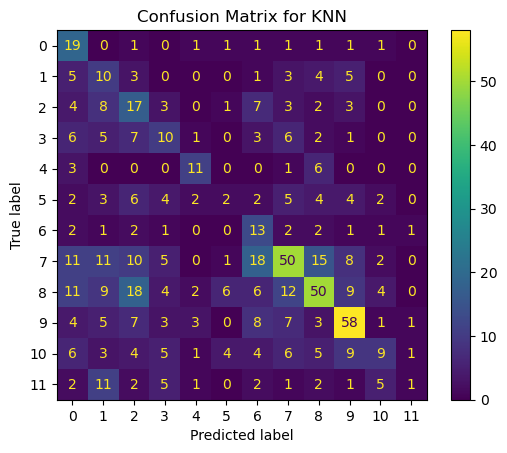

In [73]:
# cm = confusion_matrix(y_val, y_pred)
# ConfusionMatrixDisplay(cm).plot()
# plt.title(f'Confusion Matrix for KNN')
# plt.show()

In [158]:
ml_matrics = [precision_score, recall_score,f1_score]#, accuracy_score,confusion_matrix, ConfusionMatrixDisplay, ]


for i in range(len(ml_matrics)):
    print(f'{str(ml_matrics[i]).split(" ")[1]} : {ml_matrics[i](y_val, y_pred,average='micro')}')
    print(f'{str(ml_matrics[i]).split(" ")[1]} : {ml_matrics[i](y_val, y_pred,average='micro')}')
    # print(f' : {ml_matrics[i](y_val, y_pred,average='micro')}')

print(f'{str(accuracy_score).split(" ")[1]} : {accuracy_score(y_val, y_pred)}')
    


precision_score : 0.36656891495601174
recall_score : 0.36656891495601174
f1_score : 0.36656891495601174
accuracy_score : 0.36656891495601174


'tog'

## KNN comparis using functions

#### ESM models - loop for more model

In [270]:
embed_to_load = ["3B"] #["8M","35M"]
chain_type = ["together","seperate"]
linker_type = ["_<cls>"]#,"_G","_GGGGS"]


acc_scores = []
identifer = []
linker = ""
for embed in embed_to_load:
    for chains in chain_type:
        # print(chains)
        if chains =="seperate":

            print("loading")
            with open(os.path.join(embed_dir, f'embed_EMS_{embed}_{chains}'), 'rb') as f:
                esm_output = pickle.load(f)
                del esm_output["contacts"]
            layer = list(esm_output['representations'].keys())[0]

            longest_seq = 106
            linkersize = len(esm_output["representations"][layer][0]) -longest_seq -2 

            for methods in ["full_seq","cdr"]:

                # print(methods)
                X_full = extract_mean_rep(data, 
                                            chain_choice=chains,
                                            embedding = esm_output['representations'][layer],
                                            mean_method=methods,
                                            linker_size=linkersize)

                X_train = X_full[data['partition'] == 'Train']
                X_val = X_full[data['partition'] == 'Validation']
                X_test = X_full[data['partition'] == 'Test']
                y_train = data.loc[data['partition'] == 'Train', 'Epitope Group'].values
                y_val = data.loc[data['partition'] == 'Validation', 'Epitope Group'].values
                y_test = data.loc[data['partition'] == 'Test', 'Epitope Group'].values

                neigh = KNeighborsClassifier(n_neighbors=3)
                neigh.fit(X_train, y_train)

                y_pred = neigh.predict(X_val)

                acc_scores.append(accuracy_score(y_val, y_pred))
                identifer.append([embed,chains,linker,methods])


        if chains == "together":
            for index, linker in enumerate(linker_type):
                # print(linker)
                
                # print("loading")
                # with open(os.path.join(embed_dir, f'embed_EMS_{embed}_{chains}{linker}'), 'rb') as f:
                with open(os.path.join(embed_dir, f'embed_EMS_{embed}_{chains}'), 'rb') as f:
                    esm_output = pickle.load(f)
                    del esm_output["contacts"]


                layer = list(esm_output['representations'].keys())[0]

                longest_seq = 248
                linkersize = len(esm_output["representations"][layer][0]) -longest_seq -2 

                for methods in ["full_seq","cdr"]:

                    # print(methods)
                    X_full = extract_mean_rep(data, 
                                                chain_choice=chains,
                                                embedding = esm_output['representations'][layer],
                                                mean_method=methods,
                                                linker_size=linkersize)


                    X_train = X_full[data['partition'] == 'Train']
                    X_val = X_full[data['partition'] == 'Validation']
                    X_test = X_full[data['partition'] == 'Test']
                    y_train = data.loc[data['partition'] == 'Train', 'Epitope Group'].values
                    y_val = data.loc[data['partition'] == 'Validation', 'Epitope Group'].values
                    y_test = data.loc[data['partition'] == 'Test', 'Epitope Group'].values

                    neigh = KNeighborsClassifier(n_neighbors=3)
                    neigh.fit(X_train, y_train)

                    y_pred = neigh.predict(X_val)

                    acc_scores.append(accuracy_score(y_val, y_pred))
                    identifer.append([embed,chains,linker,methods])
# print(acc_scores)
# print(identifer)


loading


In [272]:
for i in range(len(identifer)):
    print(identifer[i],acc_scores[i])




['3B', 'together', '_<cls>', 'full_seq'] 0.3944281524926686
['3B', 'together', '_<cls>', 'cdr'] 0.4090909090909091
['3B', 'seperate', '_<cls>', 'full_seq'] 0.39296187683284456
['3B', 'seperate', '_<cls>', 'cdr'] 0.41055718475073316


### bolsum

In [231]:
HC_seqs = data['Heavy chain AA'].values
LC_seqs = data['Light chain AA'].values
labels = data['Epitope Group'].values



# plot_pca(seqs=HC_seqs, labels=labels,output_filename="hc_pca_blosum.png")
# plot_pca(seqs=LC_seqs, labels=labels,output_filename="lc_pca_blosum.png")
# plot_pca(seqs=hc_lc_sequences, labels=labels,output_filename="hlc_pca_blosum.png")

# hc_lc_sequences = [x + y for x, y in zip(HC_seqs, LC_seqs)]



for pool_m in ["full_seq","cdr"]:

    hc_blosum = [torch.tensor(seq) for seq in blosum_encode_seqs(HC_seqs)]
    lc_blosum = [torch.tensor(seq) for seq in blosum_encode_seqs(LC_seqs)]
    hc_lc_sequences = pooling_method(data,[hc_blosum,lc_blosum],mean_method=pool_m)


    X_train = hc_lc_sequences[data['partition'] == 'Train']
    X_val = hc_lc_sequences[data['partition'] == 'Validation']
    X_test = hc_lc_sequences[data['partition'] == 'Test']
    y_train = data.loc[data['partition'] == 'Train', 'Epitope Group'].values
    y_val = data.loc[data['partition'] == 'Validation', 'Epitope Group'].values
    y_test = data.loc[data['partition'] == 'Test', 'Epitope Group'].values

    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train, y_train)

    y_pred = neigh.predict(X_val)

    # acc_scores.append(accuracy_score(y_val, y_pred))
    # identifer.append(["bosum",pool_m])

    print(accuracy_score(y_val, y_pred))

0.28152492668621704
0.23900293255131966


# save

In [45]:

with open("file_name", 'w') as outfile:

    for i in range(len(acc_scores)):
        outfile.write(str(acc_scores[i]))
        single_string = ' '.join(identifer[i])
        outfile.write(single_string + "\n")
        


## ploting representations

### ploting acc

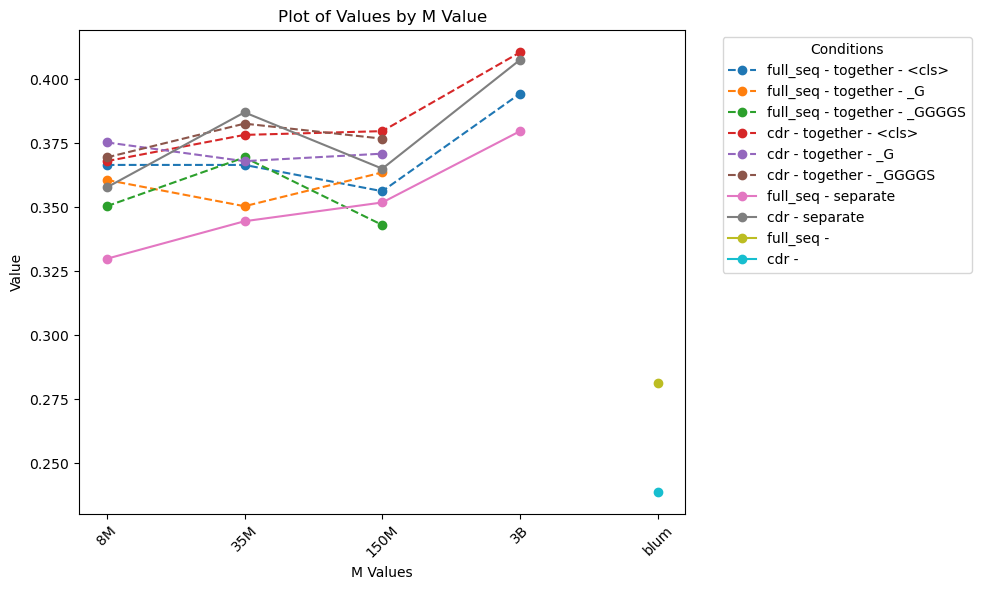

In [256]:
import matplotlib.pyplot as plt
import pandas as pd

# Data preparation
data = [
    [0.36656891495601174, '8M', 'together', 'full_seq', '<cls>'],
    [0.36803519061583588, '8M', 'together', 'cdr', '<cls>'],
    [0.36070381231671556, '8M', 'together', 'full_seq', '_G'],
    [0.37536656891495680, '8M', 'together', 'cdr', '_G'],
    [0.35043988269794724, '8M', 'together', 'full_seq', '_GGGGS'],
    [0.36950146627565983, '8M', 'together', 'cdr', '_GGGGS'],
    [0.32991202346041054, '8M', 'separate', 'full_seq', '_GGGGS'],
    [0.35777126099706746, '8M', 'separate', 'cdr', '_GGGGS'],
    [0.36656891495601174, '35M', 'together', 'full_seq', '<cls>'],
    [0.37829912023460413, '35M', 'together', 'cdr', '<cls>'],
    [0.35043988269794724, '35M', 'together', 'full_seq', '_G'],
    [0.36803519061583583, '35M', 'together', 'cdr', '_G'],
    [0.36950146627565983, '35M', 'together', 'full_seq', '_GGGGS'],
    [0.38269794721407624, '35M', 'together', 'cdr', '_GGGGS'],
    [0.34457478005865105, '35M', 'separate', 'full_seq', '_GGGGS'],
    [0.38709677419354843, '35M', 'separate', 'cdr', '_GGGGS'],
    [0.35630498533724341, '150M', 'together', 'full_seq', '<cls>'],
    [0.37976539589442815, '150M', 'together', 'cdr', '<cls>'],
    [0.36363636363636365, '150M', 'together', 'full_seq', '_G'],
    [0.37096774193548391, '150M', 'together', 'cdr', '_G'],
    [0.34310850439882695, '150M', 'together', 'full_seq', '_GGGGS'],
    [0.37683284457478006, '150M', 'together', 'cdr', '_GGGGS'],
    [0.35190615835777131, '150M', 'separate', 'full_seq', '_GGGGS'],
    [0.36510263929618771, '150M', 'separate', 'cdr', '_GGGGS'],
    [0.3944281524926686, '3B', 'together', 'full_seq', '<cls>'],
    [0.41055718475073316, '3B', 'together', 'cdr', '<cls>'],
    [0.37976539589442815, '3B', 'separate', 'full_seq', '<cls>'],
    [0.40762463343108507, '3B', 'separate', 'cdr', '<cls>'],
    [0.28152492668621704, 'blum', '', 'full_seq', ''],
    [0.23900293255131966, 'blum', '', 'cdr', '']
]

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data, columns=['Value', 'M', 'Type', 'SeqType', 'Label'])

# Set up plot
plt.figure(figsize=(10, 6))

# Plot each combination of SeqType, Type, and M
for (seq_type, typ) in df[['SeqType', 'Type']].drop_duplicates().values:
    subset = df[(df['SeqType'] == seq_type) & (df['Type'] == typ)]
    
    # If it's a 'together' type, split by 'Label'
    if typ == 'together':
        for label in subset['Label'].unique():
            label_subset = subset[subset['Label'] == label]
            plt.plot(label_subset['M'], label_subset['Value'], 
                     label=f'{seq_type} - {typ} - {label}', marker='o', linestyle='--')
    else:
        # Plot 'separate' as usual
        plt.plot(subset['M'], subset['Value'], label=f'{seq_type} - {typ}', marker='o')

# Customize plot
plt.title('Plot of Values by M Value')
plt.xlabel('M Values')
plt.ylabel('Value')
plt.legend(title='Conditions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


### plot contact

In [ ]:

def plot_concetc(some_data):

        plt.matshow(some_data["contacts"][0])
        plt.colorbar()
        return plt.show()

In [ ]:
tokens_len = [1,20,15]

# # for index in range(len(tokens)):
# for k in range(2):
#     print(k)

#     if k != 0:
#         ems_data[k] = process_linker(ems_data[k],tokens_len[k])


for index in range(len(tokens)):
    plot_concetc(ems_data[2])

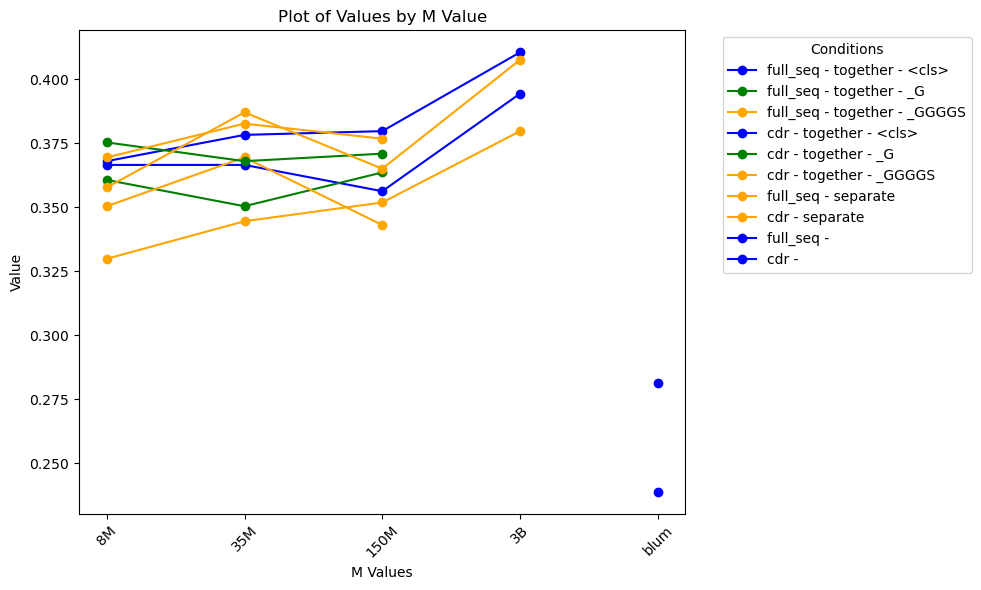

In [259]:
import matplotlib.pyplot as plt
import pandas as pd

# Data preparation
data = [
    [0.36656891495601174, '8M', 'together', 'full_seq', '<cls>'],
    [0.36803519061583588, '8M', 'together', 'cdr', '<cls>'],
    [0.36070381231671556, '8M', 'together', 'full_seq', '_G'],
    [0.37536656891495680, '8M', 'together', 'cdr', '_G'],
    [0.35043988269794724, '8M', 'together', 'full_seq', '_GGGGS'],
    [0.36950146627565983, '8M', 'together', 'cdr', '_GGGGS'],
    [0.32991202346041054, '8M', 'separate', 'full_seq', '_GGGGS'],
    [0.35777126099706746, '8M', 'separate', 'cdr', '_GGGGS'],
    [0.36656891495601174, '35M', 'together', 'full_seq', '<cls>'],
    [0.37829912023460413, '35M', 'together', 'cdr', '<cls>'],
    [0.35043988269794724, '35M', 'together', 'full_seq', '_G'],
    [0.36803519061583583, '35M', 'together', 'cdr', '_G'],
    [0.36950146627565983, '35M', 'together', 'full_seq', '_GGGGS'],
    [0.38269794721407624, '35M', 'together', 'cdr', '_GGGGS'],
    [0.34457478005865105, '35M', 'separate', 'full_seq', '_GGGGS'],
    [0.38709677419354843, '35M', 'separate', 'cdr', '_GGGGS'],
    [0.35630498533724341, '150M', 'together', 'full_seq', '<cls>'],
    [0.37976539589442815, '150M', 'together', 'cdr', '<cls>'],
    [0.36363636363636365, '150M', 'together', 'full_seq', '_G'],
    [0.37096774193548391, '150M', 'together', 'cdr', '_G'],
    [0.34310850439882695, '150M', 'together', 'full_seq', '_GGGGS'],
    [0.37683284457478006, '150M', 'together', 'cdr', '_GGGGS'],
    [0.35190615835777131, '150M', 'separate', 'full_seq', '_GGGGS'],
    [0.36510263929618771, '150M', 'separate', 'cdr', '_GGGGS'],
    [0.3944281524926686, '3B', 'together', 'full_seq', '<cls>'],
    [0.41055718475073316, '3B', 'together', 'cdr', '<cls>'],
    [0.37976539589442815, '3B', 'separate', 'full_seq', '<cls>'],
    [0.40762463343108507, '3B', 'separate', 'cdr', '<cls>'],
    [0.28152492668621704, 'blum', '', 'full_seq', ''],
    [0.23900293255131966, 'blum', '', 'cdr', '']
]

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data, columns=['Value', 'M', 'Type', 'SeqType', 'Label'])

# Set up plot
plt.figure(figsize=(10, 6))

# Define colors for different linkers
linker_colors = {
    '_G': 'green',
    '_GGGGS': 'orange',
    '<cls>': 'blue',
}

# Define a color for 'cdr' (for the line)
cdr_line_color = 'red'
other_line_color = 'black'

# Plot each combination of SeqType, Type, and M
for (seq_type, typ) in df[['SeqType', 'Type']].drop_duplicates().values:
    subset = df[(df['SeqType'] == seq_type) & (df['Type'] == typ)]
    
    # If it's a 'together' type, split by 'Label' and color the points
    if typ == 'together':
        for label in subset['Label'].unique():
            label_subset = subset[subset['Label'] == label]
            color = linker_colors.get(label, 'blue')  # Use color based on the linker
            linestyle = 'dashed' if 'cdr' in label else 'solid'  # Dash lines for cdr
            plt.plot(label_subset['M'], label_subset['Value'], 
                     label=f'{seq_type} - {typ} - {label}', 
                     marker='o', linestyle=linestyle, color=color)
    else:
        # Plot 'separate' as usual, with color for cdr line
        color = linker_colors.get(subset['Label'].values[0], 'blue')  # Use color based on linker
        linestyle = 'solid' if 'cdr' not in subset['Type'].values[0] else 'dashed'  # Line style for cdr
        plt.plot(subset['M'], subset['Value'], label=f'{seq_type} - {typ}', marker='o', color=color, linestyle=linestyle)

# Customize plot
plt.title('Plot of Values by M Value')
plt.xlabel('M Values')
plt.ylabel('Value')

# Adjust legend to handle the new labels properly
plt.legend(title='Conditions', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for clarity
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


### pca and umap